In [ ]:
# Instalar los paquetes necesarios
%pip install -r requirements.txt

In [ ]:
# Importar las librerías necesarias
# Librerías de gráficas
import matplotlib.pyplot as plt

# Librerías para manejar datos
import numpy as np
import os

# Librerías para manejar y procesar audio
import librosa
import librosa.display

# Para mostrar la barra de progreso
from tqdm import tqdm

# Escalar los datos 
from sklearn.preprocessing import StandardScaler

# Análisis de componentes principales
from sklearn.decomposition import PCA

# Guardar y cargar modelos
import joblib

In [6]:
# Rutas a las carpetas de voces reales y fake (ajusta las rutas si es necesario)
TRAIN_REAL_DIR = 'dataset/training/real'
TRAIN_FAKE_DIR = 'dataset/training/fake'
TEST_REAL_DIR = 'dataset/testing/real'
TEST_FAKE_DIR = 'dataset/testing/fake'

In [ ]:
# Funciones para cargar y extraer características de los archivos de audio (MFCC y espectrograma)
# Función para extraer características MFCC de un archivo de audio
def extract_mfcc(file_path, n_mfcc=13):
    try:
        y, sr = librosa.load(file_path, sr=None)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        mfcc_mean = np.mean(mfcc.T, axis=0)
        return mfcc_mean
    except Exception as e:
        print(f"Error al procesar {file_path}: {e}")
        return None

# Función para extraer el espectrograma de un archivo de audio con longitud fija
def extract_spectrogram(file_path, n_mels=128, max_len=1300):
    try:
        y, sr = librosa.load(file_path, sr=None)
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        log_S = librosa.power_to_db(S, ref=np.max)
        
        # Ajustar la longitud del espectrograma
        if log_S.shape[1] < max_len:
            pad_width = max_len - log_S.shape[1]
            log_S = np.pad(log_S, ((0, 0), (0, pad_width)), mode='constant')
        elif log_S.shape[1] > max_len:
            log_S = log_S[:, :max_len]
        
        return log_S.flatten()
    except Exception as e:
        print(f"Error al procesar {file_path}: {e}")
        return None

# Función para cargar audios y extraer características
def load_data_and_extract_features(directory, label, feature_type='mfcc'):
    features = []
    labels = []
    
    for filename in tqdm(os.listdir(directory)):
        if filename.endswith('.wav'):
            file_path = os.path.join(directory, filename)
            
            if feature_type == 'mfcc':
                features_data = extract_mfcc(file_path)
            elif feature_type == 'spectrogram':
                features_data = extract_spectrogram(file_path)
            else:
                print(f"Tipo de característica desconocido: {feature_type}")
                continue
                
            if features_data is not None:
                features.append(features_data)
                labels.append(label)
    
    return np.array(features), np.array(labels)

In [ ]:
#Carga de datos y extracción de características
# Lista de tipos de características a procesar
feature_types = ['mfcc', 'spectrogram']

for feature_type in feature_types:
    print(f"\nProcesando características: {feature_type.upper()}")
    
    # Extracción de características para el conjunto de entrenamiento
    print("Extrayendo características de entrenamiento...")
    X_train_real, y_train_real = load_data_and_extract_features(TRAIN_REAL_DIR, label=0, feature_type=feature_type)
    X_train_fake, y_train_fake = load_data_and_extract_features(TRAIN_FAKE_DIR, label=1, feature_type=feature_type)
    
    # Concatenar las características y etiquetas de voces reales y fake
    X_train = np.concatenate((X_train_real, X_train_fake), axis=0)
    y_train = np.concatenate((y_train_real, y_train_fake), axis=0)
    
    # Extracción de características para el conjunto de prueba
    print("Extrayendo características de prueba...")
    X_test_real, y_test_real = load_data_and_extract_features(TEST_REAL_DIR, label=0, feature_type=feature_type)
    X_test_fake, y_test_fake = load_data_and_extract_features(TEST_FAKE_DIR, label=1, feature_type=feature_type)
    
    # Concatenar las características y etiquetas de voces reales y fake
    X_test = np.concatenate((X_test_real, X_test_fake), axis=0)
    y_test = np.concatenate((y_test_real, y_test_fake), axis=0)
    
    # Guardar los datos de entrenamiento y prueba con nombres que indican el tipo de característica
    np.save(f'data_preprocessed/X_train_{feature_type}.npy', X_train)
    np.save(f'data_preprocessed/y_train_{feature_type}.npy', y_train)
    np.save(f'data_preprocessed/X_test_{feature_type}.npy', X_test)
    np.save(f'data_preprocessed/y_test_{feature_type}.npy', y_test)
    
    print(f"Datos de {feature_type.upper()} guardados exitosamente.")


In [ ]:
# Cargar los datos de características MFCC (ya procesados a datos numéricos)

# Cargar los datos de entrenamiento
X_train_mfcc = np.load('data_preprocessed/X_train_mfcc.npy')
y_train_mfcc = np.load('data_preprocessed/y_train_mfcc.npy')

# Cargar los datos de prueba
X_test_mfcc = np.load('data_preprocessed/X_test_mfcc.npy')
y_test_mfcc = np.load('data_preprocessed/y_test_mfcc.npy')

In [3]:
# Escalar los datos de los audios - MFCC
scaler_mfcc = StandardScaler()
X_train_mfcc_scaled = scaler_mfcc.fit_transform(X_train_mfcc)
X_test_mfcc_scaled = scaler_mfcc.transform(X_test_mfcc)

# Guardar los datos escalados para reutilizarlos fácilmente
np.save('data_preprocessed/scalers_PCA/X_train_mfcc_scaled.npy', X_train_mfcc_scaled)
np.save('data_preprocessed/scalers_PCA/X_test_mfcc_scaled.npy', X_test_mfcc_scaled)

# Guardar el escalador para uso futuro
joblib.dump(scaler_mfcc, 'data_preprocessed/scalers_PCA/scaler_mfcc.pkl')

['data_preprocessed/scalers_PCA/scaler_mfcc.pkl']

In [ ]:
# Cargar los datos de características Espectrograma (ya procesados a datos numéricos)

# Cargar los datos de entrenamiento
X_train_spectrogram = np.load('data_preprocessed/X_train_spectrogram.npy')
y_train_spectrogram = np.load('data_preprocessed/y_train_spectrogram.npy')

# Cargar los datos de prueba
X_test_spectrogram = np.load('data_preprocessed/X_test_spectrogram.npy')
y_test_spectrogram = np.load('data_preprocessed/y_test_spectrogram.npy')

In [5]:
# Escalar y PCA de los datos de los audios - Espectrograma

# Escalar los datos de espectrograma
scaler_spectrogram = StandardScaler()
X_train_spectrogram_scaled = scaler_spectrogram.fit_transform(X_train_spectrogram)
X_test_spectrogram_scaled = scaler_spectrogram.transform(X_test_spectrogram)

# Guardar el escalador
joblib.dump(scaler_spectrogram, 'data_preprocessed/scalers_PCA/scaler_spectrogram.pkl')

# Crear y ajustar PCA
n_components = 100 # Definir el número de componentes principales
pca = PCA(n_components=n_components, random_state=42)
X_train_spectrogram_pca = pca.fit_transform(X_train_spectrogram_scaled)
X_test_spectrogram_pca = pca.transform(X_test_spectrogram_scaled)

# Guardar los datos preprocesados
np.save('data_preprocessed/scalers_PCA/X_train_spectrogram_pca.npy', X_train_spectrogram_pca)
np.save('data_preprocessed/scalers_PCA/X_test_spectrogram_pca.npy', X_test_spectrogram_pca)

# Guardar el PCA
joblib.dump(pca, 'data_preprocessed/scalers_PCA/pca_spectrogram.pkl')

MemoryError: Unable to allocate 66.8 GiB for an array with shape (53868, 166400) and data type float64

In [ ]:
# Funciones para visualizar los MFCC y los espectrogramas
# Función para visualizar los MFCC
def plot_mfcc(file_path, n_mfcc=13, title='MFCC', ax=None):
    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    else:
        fig = ax.get_figure()
    
    img = librosa.display.specshow(mfcc, sr=sr, x_axis='time', ax=ax)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set_title(title)
    ax.set_ylabel('MFCC Coefficient')
    ax.set_xlabel('Time (s)')

# Función para visualizar el espectrograma
def plot_spectrogram(file_path, title='Espectrograma', ax=None):
    y, sr = librosa.load(file_path, sr=None)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    log_S = librosa.power_to_db(S, ref=np.max)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    else:
        fig = ax.get_figure()
    
    img = librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel', ax=ax)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set_title(title)
    ax.set_ylabel('Frequency (Hz)')
    ax.set_xlabel('Time (s)')

In [ ]:
# Rutas de los archivos de audio (graficar MFCC y espectrograma)
real_audio_path = 'dataset/validation/real/file4.wav_16k.wav_norm.wav_mono.wav_silence.wav'

fake_audio_path = 'dataset/validation/fake/file1.mp3.wav_16k.wav_norm.wav_mono.wav_silence.wav'

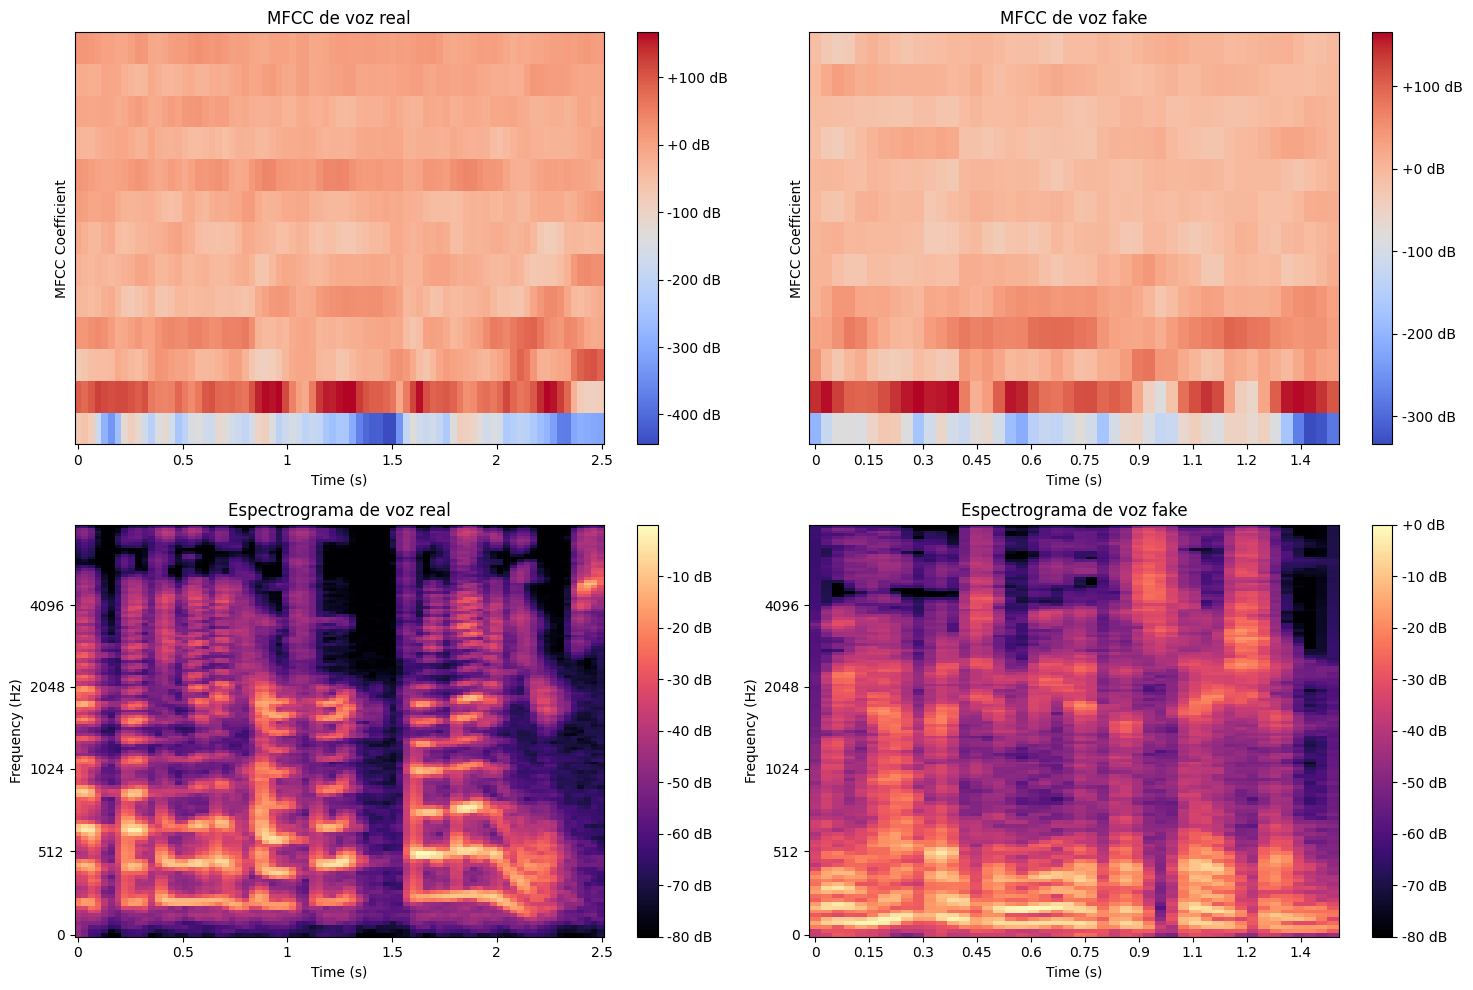

In [ ]:
# Visualizar los MFCC y los espectrogramas de los archivos de audio indicados
# Crear una figura con subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Visualizar MFCC de voz real
plot_mfcc(real_audio_path, title='MFCC de voz real', ax=axs[0, 0])

# Visualizar MFCC de voz fake
plot_mfcc(fake_audio_path, title='MFCC de voz fake', ax=axs[0, 1])

# Visualizar espectrograma de voz real
plot_spectrogram(real_audio_path, title='Espectrograma de voz real', ax=axs[1, 0])

# Visualizar espectrograma de voz fake
plot_spectrogram(fake_audio_path, title='Espectrograma de voz fake', ax=axs[1, 1])

# Ajustar el diseño
plt.tight_layout()
plt.show()